# **Lab 6 Transfer Learning & Hyperparameter Tuning**

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader,Subset,Dataset

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
import os
import cv2
from skimage.util import random_noise
from sklearn.model_selection import train_test_split
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

seed = 4912
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

## Data Preparation
Complete the class `CustomImageDataset()` that `__getitem__` return ***noisy blury*** image and ***ground truth*** image.
Please ensure that the final image is in RGBscale and has a size of 128x128.

In [5]:
### START CODE HERE ###
class CustomImageDataset(Dataset):
    def __init__(self, image_paths,gauss_noise=False,gauss_blur=None,resize=128,p=0.5, center_crop=False, transform=None):
        self.p = p
        self.resize = resize
        self.gauss_noise = gauss_noise
        self.gauss_blur = gauss_blur
        self.center_crop = center_crop
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def add_gaussian_noise(self, image):
        #สร้าง gaussian noise
        x, y, channel = image.shape
        mean = random.uniform(-50, 50)
        gaussian_noise = np.random.normal(loc=mean,scale=100,size=(x,y,channel)).astype(np.float32)
        #ภาพ ผสมกับ Gaussian Noise
        noisy_image = image + gaussian_noise
        return np.clip(noisy_image, 0, 255).astype(np.uint8)

    def do_gaussian_blur(self, image):
        kernel_size = random.randrange(3, 12, 2)
        return cv2.GaussianBlur(image, (kernel_size, kernel_size), 0) #ภาพ,Kernel Size, Standard Deviation
    
    def do_center_crop(self, image, desire_h=128, desire_w=128):
        height,width, _ = image.shape
        if width <= height: #กรณี width สั้น ให้ resize โดยยึด width 
            #ปรับ width เทียบเท่าแล้ว เหลือ Height ที่ยังเกิน
            #เพื่อให้สัดส่วนคงเดิม ไม่ถูกบีบ ให้หาอัตราส่วนภาพ
            img_ratio = height / width
            image = cv2.resize(image, (self.resize, int(self.resize*img_ratio))) #image , (width, height) ที่จะไป
            #พอ resize แล้ว จะได้ width height ตัวใหม่ 
            new_resize_h, new_resize_w, _ = image.shape
            crop_img = image[new_resize_h//2 - self.resize//2: new_resize_h//2 + self.resize//2, 0:self.resize]
        else:
            #ปรับ Height เทียบเท่าแล้ว เหลือ width ที่ยังเกิน
            img_ratio = width / height
            image = cv2.resize(image, (int(self.resize*img_ratio), self.resize))
            new_resize_h, new_resize_w, _ = image.shape
            crop_img = image[0:self.resize, new_resize_w//2 - self.resize//2: new_resize_w//2 + self.resize//2]
        return crop_img

    def __getitem__(self, idx):
        image_paths = self.image_paths[idx]
        if not os.path.exists(image_paths):
            print(f"File {image_paths} not found, skipping.")
            return torch.zeros((3, self.resize, self.resize)), 0  # Handle this case in the training loop
        img = plt.imread(image_paths)
        if img.ndim == 2: #ถ้าเป็น Gray --> บังคับเป็น RGB Format
            img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        
        #ถ้าทำ center crop ก็ไม่ต้องทำ Resize, เลือกอย่างใดอย่างนึง
        if(self.center_crop):
            gt_image = self.do_center_crop(img, desire_h=self.resize, desire_w=self.resize)
            # print("*******")
            # print(gt_image.shape)
        else:
            gt_image = cv2.resize(img, (self.resize, self.resize))  #Ground truth image
        image = gt_image.copy()

    # Ensure minimum size of 7x7
        if image.shape[0] < 7 or image.shape[1] < 7:
            image = cv2.resize(image, (max(7, image.shape[1]), max(7, image.shape[0])))
        if gt_image.shape[0] < 7 or gt_image.shape[1] < 7:
            gt_image = cv2.resize(gt_image, (max(7, gt_image.shape[1]), max(7, gt_image.shape[0])))
            
            
        #ใส่ความน่าจะเป็น ที่จะถูก Apply G-noise, G-blur
        if self.p >= 0.5:
            if self.gauss_noise:
                image = self.add_gaussian_noise(image)
            if self.gauss_blur:
                image = self.do_gaussian_blur(image)
        # print("===================")
        # print(f"Image shape: {image.shape}")
        if self.transform:
            image = self.transform(image)
            gt_image = self.transform(gt_image)
        # Print shapes for debugging
        # print(f"Image shape: {image.shape}")
        # print(f"GT image shape: {gt_image.shape}")
        return image, gt_image
### END CODE HERE ###

In [6]:
### START CODE HERE ###
def imshow_grid(images):
    fig = plt.figure(figsize=(10, 5))
    num_images = len(images)
    grid_size = int(np.ceil(np.sqrt(num_images)))
    
    for i in range(num_images):
        a = fig.add_subplot(grid_size, grid_size, i + 1)
        img = np.transpose(images[i], (1, 2, 0))
        img = np.clip(img, 0, 1)
        plt.imshow(img)
        
        a.axis("off")
    
    plt.tight_layout()
    plt.show()
### END CODE HERE ###

In [7]:
### START CODE HERE ###
data_dir = r"/home/nboonda/Lab-6-Transfer-Learning-Hyperparameter-Tuning/data/img_align_celeba"
image_paths = []
for file_name in os.listdir(data_dir):
    image_paths.append(f"{data_dir}/{file_name}")
print(image_paths)
transform = transforms.Compose([transforms.ToTensor()])
dataset = CustomImageDataset(image_paths=image_paths,
                             gauss_noise=True,
                             gauss_blur=True,
                             resize=128,
                             p=0.5,
                             center_crop=True,
                             transform=transform
                            )
dataloader = DataLoader(dataset, batch_size=16, shuffle=False,num_workers=0)
### END CODE HERE ###

['/home/nboonda/Lab-6-Transfer-Learning-Hyperparameter-Tuning/data/img_align_celeba/024858.jpg', '/home/nboonda/Lab-6-Transfer-Learning-Hyperparameter-Tuning/data/img_align_celeba/023898.jpg', '/home/nboonda/Lab-6-Transfer-Learning-Hyperparameter-Tuning/data/img_align_celeba/027350.jpg', '/home/nboonda/Lab-6-Transfer-Learning-Hyperparameter-Tuning/data/img_align_celeba/028818.jpg', '/home/nboonda/Lab-6-Transfer-Learning-Hyperparameter-Tuning/data/img_align_celeba/012091.jpg', '/home/nboonda/Lab-6-Transfer-Learning-Hyperparameter-Tuning/data/img_align_celeba/013809.jpg', '/home/nboonda/Lab-6-Transfer-Learning-Hyperparameter-Tuning/data/img_align_celeba/025876.jpg', '/home/nboonda/Lab-6-Transfer-Learning-Hyperparameter-Tuning/data/img_align_celeba/027976.jpg', '/home/nboonda/Lab-6-Transfer-Learning-Hyperparameter-Tuning/data/img_align_celeba/019024.jpg', '/home/nboonda/Lab-6-Transfer-Learning-Hyperparameter-Tuning/data/img_align_celeba/024880.jpg', '/home/nboonda/Lab-6-Transfer-Learning-

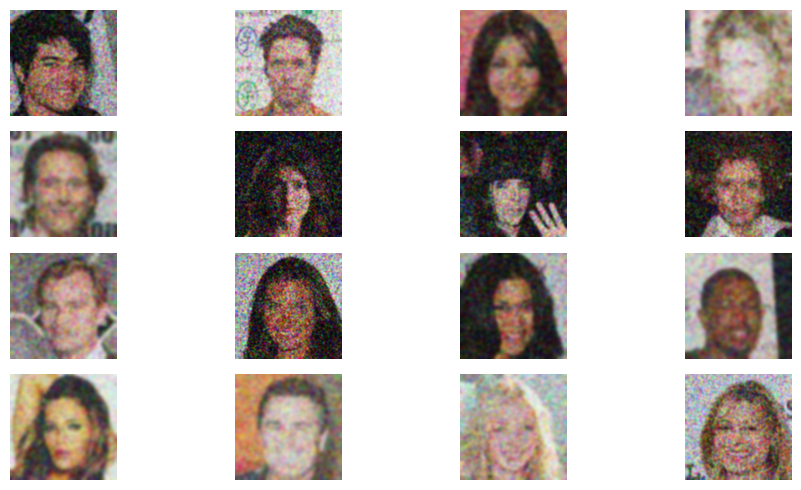

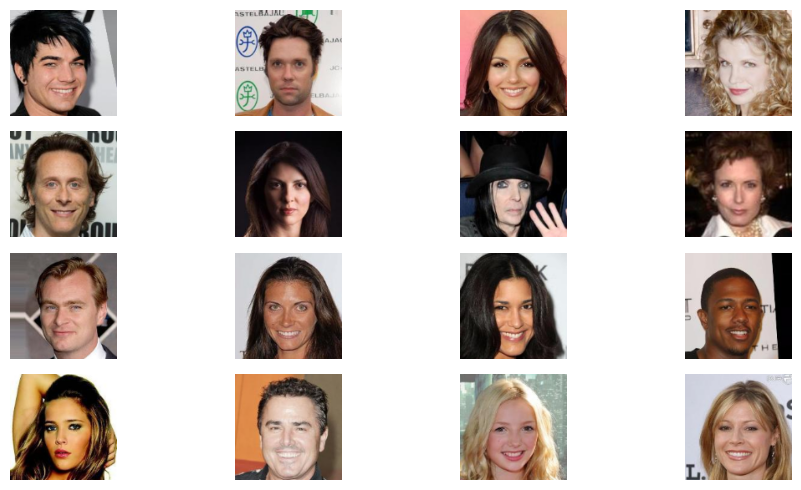

In [8]:
### START CODE HERE ###
batch,gt_img = next(iter(dataloader)) 
imshow_grid(batch.numpy())
imshow_grid(gt_img.numpy())
### END CODE HERE ###

## Create Autoencoder model
You can design your own Autoencoder model with a customizable number of downsampling and upsampling blocks by passing a list of channel numbers for each layer based on the provided code below. However, please maintain the concept of 'Autoencoder'.

In [9]:
### START CODE HERE ###
class DownSamplingBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        super(DownSamplingBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        x = self.pool(x)
        return x

class UpSamplingBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        super(UpSamplingBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        x = self.upsample(x)
        return x


class Autoencoder(nn.Module):
    def __init__(self, architecture=[64,128,256]):
        super(Autoencoder, self).__init__()
        self.architecture = architecture
        #Encoder
        
        if len(self.architecture)  == 3:
            # print("this is 3")
            # print(self.architecture[0])
            self.conv_in = nn.Conv2d(3, self.architecture[0], kernel_size=3, stride=1, padding=1)
            self.down1 = DownSamplingBlock(self.architecture[0], self.architecture[1], kernel_size=3, stride=1, padding=1)
            ### DESIGN YOUR OWN MODEL ###
            self.down2 = DownSamplingBlock(self.architecture[1], self.architecture[2], kernel_size=3, stride=1, padding=1)
            #Decoder
            self.up3 = UpSamplingBlock(self.architecture[2], self.architecture[1], kernel_size=3, stride=1, padding=1)
            self.up4 = UpSamplingBlock(self.architecture[1], self.architecture[0], kernel_size=3, stride=1, padding=1)
            self.conv = nn.Conv2d(self.architecture[0], 3, kernel_size=3, stride=1, padding=1)
        elif len(self.architecture)  == 4:
            # print("this is 4")
            self.conv_in = nn.Conv2d(3, self.architecture[0], kernel_size=3, stride=1, padding=1)
            self.down1 = DownSamplingBlock(self.architecture[0], self.architecture[1], kernel_size=3, stride=1, padding=1)
            ### DESIGN YOUR OWN MODEL ###
            self.down2 = DownSamplingBlock(self.architecture[1], self.architecture[2], kernel_size=3, stride=1, padding=1)
            self.down3 = DownSamplingBlock(self.architecture[2], self.architecture[3], kernel_size=3, stride=1, padding=1)
            #Decoder
            self.up4 = UpSamplingBlock(self.architecture[3], self.architecture[2], kernel_size=3, stride=1, padding=1)
            self.up5 = UpSamplingBlock(self.architecture[2], self.architecture[1], kernel_size=3, stride=1, padding=1)
            self.up6 = UpSamplingBlock(self.architecture[1], self.architecture[0], kernel_size=3, stride=1, padding=1)
            self.conv = nn.Conv2d(self.architecture[0], 3, kernel_size=3, stride=1, padding=1)
    #     self.conv_in = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
    #     self.down1 = DownSamplingBlock(64, 128, kernel_size=3, stride=1, padding=1)
    #     ### DESIGN YOUR OWN MODEL ###
    #     self.down2 = DownSamplingBlock(128, 256, kernel_size=3, stride=1, padding=1)
    #     #Decoder
    #     self.up3 = UpSamplingBlock(256, 128, kernel_size=3, stride=1, padding=1)
    #     self.up4 = UpSamplingBlock(128, 64, kernel_size=3, stride=1, padding=1)
    #     self.conv = nn.Conv2d(64, 3, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        if len(self.architecture)  == 3:
            x = self.conv_in(x)
            x = self.down1(x)
            x = self.down2(x)
            
            x = self.up3(x)
            x = self.up4(x)
            x = self.conv(x)
        if len(self.architecture)  == 4:
            x = self.conv_in(x)
            x = self.down1(x)
            x = self.down2(x)
            x = self.down3(x)
            
            x = self.up4(x)
            x = self.up5(x)
            x = self.up6(x)
            x = self.conv(x)
        # print(f"Model output shape: {x.shape}")
        return x
### END CODE HERE ###

## Train Autoencoder
Complete the `train()` function in the cell below. This function should evaluate the model at every epoch, log the ***training loss, test loss,test PSNR, test SSIM***. Additionally, it should save the model at the last epoch.
<details>
<summary>
<font size="3" color="orange">
<b>Expected output</b>
</font>
</summary>

- The log should resemble this, but not be identical

```
🤖Training on cuda
🚀Training Epoch [1/1]: 100%|██████████| 1313/1313 [01:45<00:00, 12.41batch/s, loss=0.0102] 
📄Testing: 100%|██████████| 563/563 [01:10<00:00,  7.95batch/s, loss=0.0106, psnr=16.7, ssim=0.348] 
Summary :
	Train	avg_loss: 0.017262999383663165
	Test	avg_loss: 0.010476540363861867 
                PSNR : 16.839487147468034 
                SSIM : 0.36090552368883694
...
```

</details>

Resource : [PyTorch Training loop](<https://pytorch.org/tutorials/beginner/introyt/trainingyt.html#:~:text=%3D0.9)-,The%20Training%20Loop,-Below%2C%20we%20have>), [PSNR & SSIM](https://ieeexplore.ieee.org/document/5596999)

In [10]:
### START CODE HERE ###
def train(model, opt, loss_fn, train_loader, test_loader, epochs=10, checkpoint_path=None, device='cpu'):
    print("🤖 Training on", device)
    model = model.to(device)

    for epoch in range(epochs):
        model.train()
        running_train_loss = 0.0
        train_bar = tqdm(train_loader, desc=f'🚀 Training Epoch [{epoch+1}/{epochs}]', unit='batch')
        for images, gt in train_bar:
            images, gt = images.to(device), gt.to(device)

            # Forward pass
            outputs = model(images)
            
            # ปรับตำแหน่ง ให้เข้า pytorch ได้
            if outputs.shape != gt.shape:
                gt = gt.permute(0, 3, 1, 2)  # เรียงแบบ [batch_size, channels, height, width]
            
            loss = loss_fn(outputs, gt)
            
            opt.zero_grad()
            loss.backward()
            opt.step()
            
            running_train_loss += loss.item()
            train_bar.set_postfix(loss=loss.item())

        avg_train_loss = running_train_loss / len(train_loader)

        # Evaluation phase (ประเมิณ เพื่อปรับปรุง)
        model.eval()
        running_test_loss = 0.0
        running_psnr = 0.0
        running_ssim = 0.0
        with torch.no_grad():
            test_bar = tqdm(test_loader, desc='📄 Testing', unit='batch')
            for images, gt in test_bar:
                images, gt = images.float().to(device), gt.float().to(device)
                
                # Forward pass
                outputs = model(images)

                # Check and adjust shape to match
                if outputs.shape != gt.shape:
                    gt = gt.permute(0, 3, 1, 2)
                
                loss = loss_fn(outputs, gt)

                # Convert tensors to numpy arrays and use permute to reorder dimensions
                outputs_np = outputs.cpu().permute(0, 2, 3, 1).numpy()
                gt_np = gt.cpu().permute(0, 2, 3, 1).numpy()
                
                # Calculate PSNR and SSIM with data range set explicitly
                data_range = gt_np.max() - gt_np.min()
                batch_psnr = np.mean([psnr(gt_np[i], outputs_np[i], data_range=data_range) for i in range(outputs_np.shape[0])])
                
                # Calculate SSIM
                batch_ssim = []
                for i in range(outputs_np.shape[0]):
                    min_dim = min(gt_np[i].shape[0], gt_np[i].shape[1])
                    if min_dim >= 7:
                        win_size = min(7, min_dim)
                        if win_size % 2 == 0:
                            win_size -= 1  # Ensure odd window size
                        ssim_value = ssim(gt_np[i], outputs_np[i], win_size=win_size, data_range=data_range, channel_axis=-1)
                    else:
                        # For images smaller than 7x7, use MSE instead of SSIM
                        ssim_value = -np.mean((gt_np[i] - outputs_np[i])**2)  # Negative MSE as a proxy for SSIM
                    batch_ssim.append(ssim_value)
                batch_ssim = np.mean(batch_ssim)

                # Summing over test losses, PSNR, and SSIM
                running_test_loss += loss.item()
                running_psnr += batch_psnr
                running_ssim += np.mean(batch_ssim)

                test_bar.set_postfix(loss=loss.item(), psnr=batch_psnr, ssim=batch_ssim)

        avg_test_loss = running_test_loss / len(test_loader)
        avg_psnr = running_psnr / len(test_loader)
        avg_ssim = running_ssim / len(test_loader)

        print(f'Summary :\n\tTrain\tavg_loss: {avg_train_loss:.4f}\n\tTest\tavg_loss: {avg_test_loss:.4f} \n\t\tPSNR : {avg_psnr:.4f} \n\t\tSSIM : {avg_ssim:.4f}')

        # Save model at the end of each epoch
        if checkpoint_path:
            torch.save(model.state_dict(), f'{checkpoint_path}_epoch_{epoch+1}.pth')
            print(f'Model saved to {checkpoint_path}_epoch_{epoch+1}.pth')
### END CODE HERE ###

Let's train your model with 2 epochs to verify that your train() function works properly. After that, we'll move on to the Hyperparameter Grid Search in the next part.

In [11]:
### START CODE HERE ###
data_dir = r"/home/nboonda/Lab-6-Transfer-Learning-Hyperparameter-Tuning/data/img_align_celeba"

# files = os.listdir(data_dir)
# files = [os.path.normpath(os.path.join(data_dir, file)) for file in files]
# print(files)
files = []
for file_name in os.listdir(data_dir):
    files.append(f"{data_dir}/{file_name}")
print(files[0])

# Split ข้อมูล
transform = transforms.Compose([transforms.ToTensor()])

# Split data
train_files, test_files = train_test_split(image_paths, test_size=0.2, random_state=42)
train_dataset = CustomImageDataset(image_paths=train_files,
                            gauss_noise=True,
                            gauss_blur=True,
                            resize=128,
                            p=0.5,
                            center_crop=True,
                            transform=transform)
test_dataset = CustomImageDataset(image_paths=test_files,
                            gauss_noise=True,
                            gauss_blur=True,
                            resize=128,
                            p=0.5,
                            center_crop=True,
                            transform=transform)
trainloader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=0)
testloader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=0)
### END CODE HERE ###

/home/nboonda/Lab-6-Transfer-Learning-Hyperparameter-Tuning/data/img_align_celeba/024858.jpg


In [12]:
### START CODE HERE ###
#อันนี้ไม่ต้องรันแล้ว มีแล้ว
#อันนี้ไม่ต้องรันแล้ว มีแล้ว
#อันนี้ไม่ต้องรันแล้ว มีแล้ว
#อันนี้ไม่ต้องรันแล้ว มีแล้ว
#อันนี้ไม่ต้องรันแล้ว มีแล้ว
#อันนี้ไม่ต้องรันแล้ว มีแล้ว
#อันนี้ไม่ต้องรันแล้ว มีแล้ว
#อันนี้ไม่ต้องรันแล้ว มีแล้ว
#อันนี้ไม่ต้องรันแล้ว มีแล้ว
#อันนี้ไม่ต้องรันแล้ว มีแล้ว
model = Autoencoder(architecture=[64, 128, 256]) 
opt = optim.Adam(model.parameters(), lr=1e-3) 
loss_fn = nn.MSELoss()
train(model, opt, loss_fn, trainloader, testloader, epochs=2, checkpoint_path='autoencoder.pth', device='cuda' if torch.cuda.is_available() else 'cpu')
### END CODE HERE ###

🤖 Training on cuda


📄 Testing: 100%|██████████| 375/375 [01:31<00:00,  4.08batch/s, loss=0.0125, psnr=19.3, ssim=0.541] 


Summary :
	Train	avg_loss: 0.0167
	Test	avg_loss: 0.0132 
		PSNR : 19.3093 
		SSIM : 0.5628
Model saved to autoencoder.pth_epoch_1.pth


📄 Testing: 100%|██████████| 375/375 [01:18<00:00,  4.79batch/s, loss=0.0113, psnr=19.8, ssim=0.6]   

Summary :
	Train	avg_loss: 0.0129
	Test	avg_loss: 0.0113 
		PSNR : 19.9327 
		SSIM : 0.5998
Model saved to autoencoder.pth_epoch_2.pth


---

## **Hyperparameter Grid Search with Raytune**

*If you have access to APEX, I would recommend converting this part into a Python file and submitting the job to run on APEX using SBATCH. This process may take a considerable amount of time.*

You can import additional Ray Tune tools as you want, such as schedulers, search algorithms, etc. Further information on the usage of Ray Tune can be found [here](https://docs.ray.io/en/latest/tune/index.html).

In [36]:
import ray
from ray import tune
from ray.air import session


ray.shutdown()

/home/nboonda/miniconda3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-09-29 21:27:42,728	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2024-09-29 21:27:42,921	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


Complete the `train_raytune()` function below, following the [quick start guide](https://docs.ray.io/en/latest/tune/index.html). This function will be passed to the `tune.Tuner`.

In [38]:
### START CODE HERE ###
def train_raytune(config):
    # Extract hyperparameters from config
    architecture = config["architecture"]
    lr = config["lr"]
    batch_size = config["batch_size"]
    num_epochs = config["num_epochs"]
    optimizer = config["optimizer"]
    
    # Transform
    transform = transforms.Compose([transforms.ToTensor()])

    # Split data
    train_files, test_files = train_test_split(image_paths, test_size=0.2, random_state=42)
    train_dataset = CustomImageDataset(image_paths=train_files,
                                gauss_noise=True,
                                gauss_blur=True,
                                resize=128,
                                p=0.5,
                                center_crop=True,
                                transform=transform)
    test_dataset = CustomImageDataset(image_paths=test_files,
                                gauss_noise=True,
                                gauss_blur=True,
                                resize=128,
                                p=0.5,
                                center_crop=True,
                                transform=transform)
    trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    testloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

    # Verify dataset output shapes
    train_batch, train_gt = next(iter(trainloader))
    test_batch, test_gt = next(iter(testloader)) 

    # print(f"Train batch shape: {train_batch.shape}")
    # print(f"Train GT batch shape: {train_gt.shape}")
    # print(f"Test batch shape: {test_batch.shape}")
    # print(f"Test GT batch shape: {test_gt.shape}")

    device = "cuda" if torch.cuda.is_available() else "cpu"
    model = Autoencoder(architecture)  # Ensure the model architecture is consistent
    model = model.to(device)
    loss_fn = nn.MSELoss()
    
    if optimizer == 'Adam':
        opt = torch.optim.Adam(model.parameters(), lr=lr)
    elif optimizer == 'SGD':
        opt = torch.optim.SGD(model.parameters(), lr=lr)
        
    for epoch in range(num_epochs):
        model.train()
        avg_train_loss = 0
        avg_test_loss = 0
        for batch in trainloader:
            images, train_gt_img = batch  # unpack the batch
            
            # Print shapes for debugging
            # print(f"Training image shape: {images.shape}")
            # print(f"Training GT image shape: {train_gt_img.shape}")

            # Move data to the device
            images = images.to(device)
            train_gt_img = train_gt_img.to(device)
            
            # Forward pass
            output = model(images)
            
            # Print model output shape for debugging
            # print(f"Model output shape: {output.shape}")
            
            # Compute the loss
            loss = loss_fn(output, train_gt_img)
            
            # Backpropagation and optimization step
            opt.zero_grad()
            loss.backward()
            opt.step()

            # Track the training loss
            avg_train_loss += loss.item()
            
        avg_train_loss /= len(trainloader)
        
        total_psnr = 0
        total_ssim = 0
        model.eval()
        with torch.no_grad():
            for batch in testloader:
                images, test_gt_img = batch
                images = images.to(device)
                test_gt_img = test_gt_img.to(device)
                
                output = model(images)
                
                loss = loss_fn(output, test_gt_img)
                avg_test_loss += loss.item()
                
                output_np = output.cpu().numpy().transpose(0, 2, 3, 1)
                images_np = test_gt_img.cpu().numpy().transpose(0, 2, 3, 1)
                
                for i in range(images_np.shape[0]):  # Use actual batch size
                    img = images_np[i]
                    rec_img = output_np[i]
                    total_psnr += psnr(img, rec_img, data_range=1.0)
                    
                    # Adjust SSIM calculation
                    min_dim = min(img.shape[0], img.shape[1])
                    win_size = min(7, min_dim)  # Use 7 or smaller odd number
                    if win_size % 2 == 0:
                        win_size -= 1  # Ensure odd window size
                    total_ssim += ssim(img, rec_img, win_size=win_size, data_range=1.0, channel_axis=2)
        
        # Average the PSNR, SSIM, and loss over the test dataset
        avg_psnr = total_psnr / (len(testloader.dataset))
        avg_ssim = total_ssim / (len(testloader.dataset))
        avg_test_loss /= len(testloader)
        
        # Report results to Ray Tune
        session.report({
            "train_loss": avg_train_loss,
            "val_loss": avg_test_loss,
            "val_psnr": avg_psnr,
            "val_ssim": avg_ssim,
        })
        
### END CODE HERE ###

Initialize Ray, define the search space, and resources.

Resource : 
- [A Guide To Parallelism and Resources for Ray Tune](https://docs.ray.io/en/latest/tune/tutorials/tune-resources.html#:~:text=A%20Guide%20To%20Parallelism%20and%20Resources%20for%20Ray%20Tune) 
- [Working with Tune Search Spaces](https://docs.ray.io/en/latest/tune/tutorials/tune-search-spaces.html#tune-search-space-tutorial:~:text=Working%20with%20Tune%20Search%20Spaces)
- [How to configure logging in Tune?](https://docs.ray.io/en/latest/tune/tutorials/tune-output.html) 
- [Tune Trial Schedulers (`tune.schedulers`)](https://docs.ray.io/en/latest/tune/api/schedulers.html#tune-scheduler-pbt:~:text=Tune%20Trial...-,Tune%20Trial%20Schedulers%20(tune.schedulers),-%23)

**Search Space:**
- `architecture`:<br>
    Feature map dimensions for convolutional layers<br>
    - `[32, 64, 128]`: 3 downsampling layers with feature maps increasing from 32 to 128.
    - `[64, 128, 256]`: 3 downsampling layers with feature maps starting from 64 to 256.
    - `[64, 128, 256, 512]`: 4 downsampling layers with more depth, starting from 64 and ending at 512.
- `learning rates (lr)`:
    - [1e-3, 8e-4, 1e-4, 1e-2]: Test a wide range of learning rates to evaluate model performance, from 1e-3 (typical) to a more aggressive 1e-2 or conservative 1e-4.
- `batch size`:
    - [16, 32]: Explore smaller batch sizes to evaluate their impact on gradient estimation and memory usage.
- `number of epochs`:
    - `[10, 50, 100]`: Allow short and long training sessions, from quick evaluations (10 epochs) to more extensive training (100 epochs).
- `optimizers (opts)`:
    - `["Adam", "SGD"]`: Compare two popular optimization algorithms: Adam for adaptive learning rates and SGD for momentum-based updates.

In [16]:
### START CODE HERE ###
#อันนี้ไม่ต้องรันแล้ว มีแล้ว

ray.init(num_gpus=1, ignore_reinit_error=True)

# Define the trial directory naming function
def short_dirname(trial):
    return "trial_" + str(trial.trial_id)

config = {
    'architecture': tune.grid_search([[32, 64, 128], [64, 128, 256], [64, 128, 256, 512]]),
    "lr": tune.grid_search([1e-3, 1e-4, 1e-2]),
    "batch_size": tune.grid_search([16, 32]),
    "num_epochs": tune.grid_search([10, 50, 100]),
    'optimizer': tune.grid_search(['Adam', 'SGD']),
}

result = tune.run(
    tune.with_resources(train_raytune, resources={"gpu": 0.5}),
    config=config,
    metric="val_psnr",
    mode="max",
    trial_dirname_creator=short_dirname
)

print("Best config: ", result.get_best_config(metric="val_psnr", mode="max"))
### END CODE HERE ###

2024-09-20 19:32:23,802	INFO worker.py:1783 -- Started a local Ray instance.
2024-09-20 19:32:37,382	INFO tune.py:616 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


2024-09-20 19:32:37,465	WARNING tune_controller.py:2132 -- The maximum number of pending trials has been automatically set to the number of available cluster CPUs, which is high (281 CPUs/pending trials). If you're running an experiment with a large number of trials, this could lead to scheduling overhead. In this case, consider setting the `TUNE_MAX_PENDING_TRIALS_PG` environment variable to the desired maximum number of concurrent pending trials.
2024-09-20 19:32:37,468	WARNING tune_controller.py:2132 -- The maximum number of pending trials has been automatically set to the number of available cluster CPUs, which is high (281 CPUs/pending trials). If you're running an experiment with a large number of trials, this could lead to scheduling overhead. In this case, consider setting the `TUNE_MAX_PENDING_TRIALS_PG` environment variable to the desired maximum number of concurrent pending trials.


Trial name,train_loss,val_loss,val_psnr,val_ssim
train_raytune_6b602_00000,0.016529,0.0128637,19.3161,0.585748
train_raytune_6b602_00001,0.0181848,0.0120283,19.5753,0.585571


Restore the result from path of ray resule directory

In [39]:
### START CODE HERE ###
import pandas as pd
path = r"/home/nboonda/Lab-6-Transfer-Learning-Hyperparameter-Tuning/train_raytune_2024-09-20_19-32-37"
# restored_tuner = tune.Tuner.restore(path, trainable='train_raytune')

# Set your base directory
base_dir = '/home/nboonda/Lab-6-Transfer-Learning-Hyperparameter-Tuning/train_raytune_2024-09-20_19-32-37'
best_val_psnr = float('-inf')
best_info = {}

# Traverse through all trial folders
for trial_folder in os.listdir(base_dir):
    trial_path = os.path.join(base_dir, trial_folder)
    progress_file = os.path.join(trial_path, 'progress.csv')

    # Check if progress.csv exists in the trial folder
    if os.path.isfile(progress_file):
        # Load the CSV file into a DataFrame
        df = pd.read_csv(progress_file)

        # Get the row with the maximum val_psnr in the current file
        if 'val_psnr' in df.columns:
            max_val_psnr_row = df.loc[df['val_psnr'].idxmax()]

            # Compare with the global best val_psnr
            if max_val_psnr_row['val_psnr'] > best_val_psnr:
                best_val_psnr = max_val_psnr_row['val_psnr']
                best_info = {
                    'trial_folder': trial_folder,
                    'val_psnr': max_val_psnr_row['val_psnr'],
                    'iterations_since_restore': max_val_psnr_row['iterations_since_restore'],
                    'progress_df': df
                }

### END CODE HERE ###

Get the report from Grid Search to CSV file.

In [40]:

import json

# Open and read the JSON file
best_path = os.path.join(path,best_info['trial_folder'])
with open(os.path.join(best_path,'params.json'), 'r') as file:
    best_param = json.load(file)

print("🎉[INFO] Training is done!")
print("Best config is:", best_param)
print("Best result is:", best_info['trial_folder'],f"Iterations number: {best_info['iterations_since_restore']}",f"which has best val_psnr: {best_val_psnr}")
df = best_info['progress_df']
print(df)


🎉[INFO] Training is done!
Best config is: {'architecture': [64, 128, 256, 512], 'batch_size': 16, 'lr': 0.001, 'num_epochs': 100, 'optimizer': 'Adam'}
Best result is: trial_6b602_00038 Iterations number: 95 which has best val_psnr: 23.018518375624023
    train_loss  val_loss   val_psnr  val_ssim   timestamp  \
0     0.017877  0.017618  18.294388  0.536416  1726921320   
1     0.011953  0.010207  20.224615  0.582350  1726921465   
2     0.010414  0.010024  20.327593  0.597550  1726921608   
3     0.009687  0.009049  20.828529  0.614334  1726921752   
4     0.009204  0.008487  21.047422  0.621558  1726921896   
..         ...       ...        ...       ...         ...   
95    0.005576  0.005705  22.770497  0.703767  1726935050   
96    0.005578  0.005541  22.914190  0.700011  1726935198   
97    0.005575  0.005465  22.998052  0.702640  1726935343   
98    0.005558  0.005583  22.937580  0.700638  1726935485   
99    0.005580  0.005554  22.888277  0.700793  1726935631   

    checkpoint_d

---

Train the Autoencoder models using the best hyperparameter set obtained from the grid search.

In [20]:
### START CODE HERE ###
# Best config is: {'architecture': [64, 128, 256, 512], 'batch_size': 16, 'lr': 0.001, 'num_epochs': 100, 'optimizer': 'Adam'} but best at 95
model = Autoencoder(architecture=[64, 128, 256, 512]) 
opt = optim.Adam(model.parameters(), lr=0.001) 
loss_fn = nn.MSELoss()

# Transform
transform = transforms.Compose([transforms.ToTensor()])

# Split data
train_files, test_files = train_test_split(image_paths, test_size=0.2, random_state=42)
train_dataset = CustomImageDataset(image_paths=train_files,
                            gauss_noise=True,
                            gauss_blur=True,
                            resize=128,
                            p=0.5,
                            center_crop=True,
                            transform=transform)
test_dataset = CustomImageDataset(image_paths=test_files,
                            gauss_noise=True,
                            gauss_blur=True,
                            resize=128,
                            p=0.5,
                            center_crop=True,
                            transform=transform)
trainloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
testloader = DataLoader(test_dataset, batch_size=16, shuffle=False)

train(model, opt, loss_fn, trainloader, testloader, epochs=95, checkpoint_path='/home/nboonda/Lab-6-Transfer-Learning-Hyperparameter-Tuning/best_gridsearch/AE_best_grid', device='cuda' if torch.cuda.is_available() else 'cpu')
### END CODE HERE ###

🤖 Training on cuda


📄 Testing: 100%|██████████| 375/375 [00:59<00:00,  6.31batch/s, loss=0.0155, psnr=18.5, ssim=0.517]


Summary :
	Train	avg_loss: 0.0190
	Test	avg_loss: 0.0149 
		PSNR : 18.7276 
		SSIM : 0.5238
Model saved to /home/nboonda/Lab-6-Transfer-Learning-Hyperparameter-Tuning/best_gridsearch/AE_best_grid_epoch_1.pth


📄 Testing: 100%|██████████| 375/375 [00:53<00:00,  6.95batch/s, loss=0.0117, psnr=19.9, ssim=0.579] 


Summary :
	Train	avg_loss: 0.0124
	Test	avg_loss: 0.0110 
		PSNR : 20.0536 
		SSIM : 0.5840
Model saved to /home/nboonda/Lab-6-Transfer-Learning-Hyperparameter-Tuning/best_gridsearch/AE_best_grid_epoch_2.pth


📄 Testing: 100%|██████████| 375/375 [00:58<00:00,  6.46batch/s, loss=0.011, psnr=20, ssim=0.6]      


Summary :
	Train	avg_loss: 0.0106
	Test	avg_loss: 0.0101 
		PSNR : 20.2788 
		SSIM : 0.5953
Model saved to /home/nboonda/Lab-6-Transfer-Learning-Hyperparameter-Tuning/best_gridsearch/AE_best_grid_epoch_3.pth


📄 Testing: 100%|██████████| 375/375 [01:13<00:00,  5.08batch/s, loss=0.0115, psnr=20, ssim=0.614]   


Summary :
	Train	avg_loss: 0.0099
	Test	avg_loss: 0.0096 
		PSNR : 20.4811 
		SSIM : 0.6107
Model saved to /home/nboonda/Lab-6-Transfer-Learning-Hyperparameter-Tuning/best_gridsearch/AE_best_grid_epoch_4.pth


📄 Testing: 100%|██████████| 375/375 [01:01<00:00,  6.06batch/s, loss=0.00761, psnr=21.4, ssim=0.629]


Summary :
	Train	avg_loss: 0.0093
	Test	avg_loss: 0.0079 
		PSNR : 21.3471 
		SSIM : 0.6278
Model saved to /home/nboonda/Lab-6-Transfer-Learning-Hyperparameter-Tuning/best_gridsearch/AE_best_grid_epoch_5.pth


📄 Testing: 100%|██████████| 375/375 [01:08<00:00,  5.44batch/s, loss=0.00819, psnr=21, ssim=0.632]  


Summary :
	Train	avg_loss: 0.0088
	Test	avg_loss: 0.0090 
		PSNR : 20.8514 
		SSIM : 0.6306
Model saved to /home/nboonda/Lab-6-Transfer-Learning-Hyperparameter-Tuning/best_gridsearch/AE_best_grid_epoch_6.pth


📄 Testing: 100%|██████████| 375/375 [01:16<00:00,  4.93batch/s, loss=0.00816, psnr=21, ssim=0.635]  


Summary :
	Train	avg_loss: 0.0086
	Test	avg_loss: 0.0089 
		PSNR : 20.9364 
		SSIM : 0.6356
Model saved to /home/nboonda/Lab-6-Transfer-Learning-Hyperparameter-Tuning/best_gridsearch/AE_best_grid_epoch_7.pth


📄 Testing: 100%|██████████| 375/375 [01:26<00:00,  4.36batch/s, loss=0.00874, psnr=21.1, ssim=0.644]


Summary :
	Train	avg_loss: 0.0082
	Test	avg_loss: 0.0077 
		PSNR : 21.5307 
		SSIM : 0.6484
Model saved to /home/nboonda/Lab-6-Transfer-Learning-Hyperparameter-Tuning/best_gridsearch/AE_best_grid_epoch_8.pth


📄 Testing: 100%|██████████| 375/375 [01:00<00:00,  6.19batch/s, loss=0.00793, psnr=21.6, ssim=0.64] 


Summary :
	Train	avg_loss: 0.0080
	Test	avg_loss: 0.0073 
		PSNR : 21.7135 
		SSIM : 0.6449
Model saved to /home/nboonda/Lab-6-Transfer-Learning-Hyperparameter-Tuning/best_gridsearch/AE_best_grid_epoch_9.pth


📄 Testing: 100%|██████████| 375/375 [01:10<00:00,  5.34batch/s, loss=0.00601, psnr=22.3, ssim=0.652]


Summary :
	Train	avg_loss: 0.0078
	Test	avg_loss: 0.0073 
		PSNR : 21.7768 
		SSIM : 0.6502
Model saved to /home/nboonda/Lab-6-Transfer-Learning-Hyperparameter-Tuning/best_gridsearch/AE_best_grid_epoch_10.pth


📄 Testing: 100%|██████████| 375/375 [01:01<00:00,  6.06batch/s, loss=0.00755, psnr=21.5, ssim=0.656]


Summary :
	Train	avg_loss: 0.0076
	Test	avg_loss: 0.0072 
		PSNR : 21.7887 
		SSIM : 0.6590
Model saved to /home/nboonda/Lab-6-Transfer-Learning-Hyperparameter-Tuning/best_gridsearch/AE_best_grid_epoch_11.pth


📄 Testing: 100%|██████████| 375/375 [01:23<00:00,  4.47batch/s, loss=0.00701, psnr=21.7, ssim=0.664]


Summary :
	Train	avg_loss: 0.0074
	Test	avg_loss: 0.0070 
		PSNR : 21.8991 
		SSIM : 0.6640
Model saved to /home/nboonda/Lab-6-Transfer-Learning-Hyperparameter-Tuning/best_gridsearch/AE_best_grid_epoch_12.pth


📄 Testing: 100%|██████████| 375/375 [00:59<00:00,  6.30batch/s, loss=0.00678, psnr=21.9, ssim=0.665]


Summary :
	Train	avg_loss: 0.0072
	Test	avg_loss: 0.0070 
		PSNR : 21.8804 
		SSIM : 0.6641
Model saved to /home/nboonda/Lab-6-Transfer-Learning-Hyperparameter-Tuning/best_gridsearch/AE_best_grid_epoch_13.pth


📄 Testing: 100%|██████████| 375/375 [01:01<00:00,  6.14batch/s, loss=0.00706, psnr=21.8, ssim=0.656]


Summary :
	Train	avg_loss: 0.0072
	Test	avg_loss: 0.0069 
		PSNR : 21.9954 
		SSIM : 0.6630
Model saved to /home/nboonda/Lab-6-Transfer-Learning-Hyperparameter-Tuning/best_gridsearch/AE_best_grid_epoch_14.pth


📄 Testing: 100%|██████████| 375/375 [00:59<00:00,  6.34batch/s, loss=0.00798, psnr=21.7, ssim=0.67] 


Summary :
	Train	avg_loss: 0.0071
	Test	avg_loss: 0.0069 
		PSNR : 22.0533 
		SSIM : 0.6662
Model saved to /home/nboonda/Lab-6-Transfer-Learning-Hyperparameter-Tuning/best_gridsearch/AE_best_grid_epoch_15.pth


📄 Testing: 100%|██████████| 375/375 [00:57<00:00,  6.52batch/s, loss=0.00657, psnr=22.1, ssim=0.677]


Summary :
	Train	avg_loss: 0.0070
	Test	avg_loss: 0.0069 
		PSNR : 21.9617 
		SSIM : 0.6710
Model saved to /home/nboonda/Lab-6-Transfer-Learning-Hyperparameter-Tuning/best_gridsearch/AE_best_grid_epoch_16.pth


📄 Testing: 100%|██████████| 375/375 [01:05<00:00,  5.72batch/s, loss=0.00673, psnr=22, ssim=0.664]  


Summary :
	Train	avg_loss: 0.0069
	Test	avg_loss: 0.0065 
		PSNR : 22.2117 
		SSIM : 0.6746
Model saved to /home/nboonda/Lab-6-Transfer-Learning-Hyperparameter-Tuning/best_gridsearch/AE_best_grid_epoch_17.pth


📄 Testing: 100%|██████████| 375/375 [00:59<00:00,  6.28batch/s, loss=0.00627, psnr=22.3, ssim=0.669]


Summary :
	Train	avg_loss: 0.0069
	Test	avg_loss: 0.0064 
		PSNR : 22.2926 
		SSIM : 0.6756
Model saved to /home/nboonda/Lab-6-Transfer-Learning-Hyperparameter-Tuning/best_gridsearch/AE_best_grid_epoch_18.pth


📄 Testing: 100%|██████████| 375/375 [01:04<00:00,  5.84batch/s, loss=0.00669, psnr=22, ssim=0.673]  


Summary :
	Train	avg_loss: 0.0067
	Test	avg_loss: 0.0064 
		PSNR : 22.2796 
		SSIM : 0.6734
Model saved to /home/nboonda/Lab-6-Transfer-Learning-Hyperparameter-Tuning/best_gridsearch/AE_best_grid_epoch_19.pth


📄 Testing: 100%|██████████| 375/375 [00:54<00:00,  6.83batch/s, loss=0.00617, psnr=22.3, ssim=0.67] 


Summary :
	Train	avg_loss: 0.0067
	Test	avg_loss: 0.0065 
		PSNR : 22.2344 
		SSIM : 0.6678
Model saved to /home/nboonda/Lab-6-Transfer-Learning-Hyperparameter-Tuning/best_gridsearch/AE_best_grid_epoch_20.pth


📄 Testing: 100%|██████████| 375/375 [00:58<00:00,  6.46batch/s, loss=0.0071, psnr=21.9, ssim=0.676] 


Summary :
	Train	avg_loss: 0.0066
	Test	avg_loss: 0.0065 
		PSNR : 22.2152 
		SSIM : 0.6752
Model saved to /home/nboonda/Lab-6-Transfer-Learning-Hyperparameter-Tuning/best_gridsearch/AE_best_grid_epoch_21.pth


📄 Testing: 100%|██████████| 375/375 [02:12<00:00,  2.82batch/s, loss=0.00519, psnr=22.9, ssim=0.679]


Summary :
	Train	avg_loss: 0.0066
	Test	avg_loss: 0.0062 
		PSNR : 22.3984 
		SSIM : 0.6780
Model saved to /home/nboonda/Lab-6-Transfer-Learning-Hyperparameter-Tuning/best_gridsearch/AE_best_grid_epoch_22.pth


📄 Testing: 100%|██████████| 375/375 [01:30<00:00,  4.17batch/s, loss=0.00652, psnr=22.2, ssim=0.674]


Summary :
	Train	avg_loss: 0.0065
	Test	avg_loss: 0.0064 
		PSNR : 22.2993 
		SSIM : 0.6804
Model saved to /home/nboonda/Lab-6-Transfer-Learning-Hyperparameter-Tuning/best_gridsearch/AE_best_grid_epoch_23.pth


📄 Testing: 100%|██████████| 375/375 [01:06<00:00,  5.66batch/s, loss=0.0057, psnr=22.6, ssim=0.68]  


Summary :
	Train	avg_loss: 0.0065
	Test	avg_loss: 0.0062 
		PSNR : 22.4390 
		SSIM : 0.6827
Model saved to /home/nboonda/Lab-6-Transfer-Learning-Hyperparameter-Tuning/best_gridsearch/AE_best_grid_epoch_24.pth


📄 Testing: 100%|██████████| 375/375 [00:58<00:00,  6.42batch/s, loss=0.00621, psnr=22.4, ssim=0.687]


Summary :
	Train	avg_loss: 0.0065
	Test	avg_loss: 0.0066 
		PSNR : 22.1521 
		SSIM : 0.6797
Model saved to /home/nboonda/Lab-6-Transfer-Learning-Hyperparameter-Tuning/best_gridsearch/AE_best_grid_epoch_25.pth


📄 Testing: 100%|██████████| 375/375 [01:28<00:00,  4.22batch/s, loss=0.00621, psnr=22.4, ssim=0.677]


Summary :
	Train	avg_loss: 0.0065
	Test	avg_loss: 0.0061 
		PSNR : 22.5385 
		SSIM : 0.6797
Model saved to /home/nboonda/Lab-6-Transfer-Learning-Hyperparameter-Tuning/best_gridsearch/AE_best_grid_epoch_26.pth


📄 Testing: 100%|██████████| 375/375 [01:54<00:00,  3.27batch/s, loss=0.00683, psnr=22.1, ssim=0.681]


Summary :
	Train	avg_loss: 0.0064
	Test	avg_loss: 0.0062 
		PSNR : 22.4071 
		SSIM : 0.6836
Model saved to /home/nboonda/Lab-6-Transfer-Learning-Hyperparameter-Tuning/best_gridsearch/AE_best_grid_epoch_27.pth


📄 Testing: 100%|██████████| 375/375 [01:37<00:00,  3.83batch/s, loss=0.00554, psnr=22.7, ssim=0.684]


Summary :
	Train	avg_loss: 0.0063
	Test	avg_loss: 0.0065 
		PSNR : 22.3592 
		SSIM : 0.6850
Model saved to /home/nboonda/Lab-6-Transfer-Learning-Hyperparameter-Tuning/best_gridsearch/AE_best_grid_epoch_28.pth


📄 Testing: 100%|██████████| 375/375 [01:06<00:00,  5.65batch/s, loss=0.00504, psnr=23.1, ssim=0.682]


Summary :
	Train	avg_loss: 0.0063
	Test	avg_loss: 0.0064 
		PSNR : 22.3009 
		SSIM : 0.6787
Model saved to /home/nboonda/Lab-6-Transfer-Learning-Hyperparameter-Tuning/best_gridsearch/AE_best_grid_epoch_29.pth


📄 Testing: 100%|██████████| 375/375 [01:07<00:00,  5.54batch/s, loss=0.0054, psnr=22.8, ssim=0.684] 


Summary :
	Train	avg_loss: 0.0063
	Test	avg_loss: 0.0060 
		PSNR : 22.5757 
		SSIM : 0.6856
Model saved to /home/nboonda/Lab-6-Transfer-Learning-Hyperparameter-Tuning/best_gridsearch/AE_best_grid_epoch_30.pth


📄 Testing: 100%|██████████| 375/375 [01:14<00:00,  5.04batch/s, loss=0.00634, psnr=22.5, ssim=0.692]


Summary :
	Train	avg_loss: 0.0063
	Test	avg_loss: 0.0059 
		PSNR : 22.6524 
		SSIM : 0.6879
Model saved to /home/nboonda/Lab-6-Transfer-Learning-Hyperparameter-Tuning/best_gridsearch/AE_best_grid_epoch_31.pth


📄 Testing: 100%|██████████| 375/375 [01:57<00:00,  3.20batch/s, loss=0.00572, psnr=22.5, ssim=0.677]


Summary :
	Train	avg_loss: 0.0063
	Test	avg_loss: 0.0064 
		PSNR : 22.2700 
		SSIM : 0.6802
Model saved to /home/nboonda/Lab-6-Transfer-Learning-Hyperparameter-Tuning/best_gridsearch/AE_best_grid_epoch_32.pth


📄 Testing: 100%|██████████| 375/375 [00:57<00:00,  6.47batch/s, loss=0.00648, psnr=22.3, ssim=0.678]


Summary :
	Train	avg_loss: 0.0063
	Test	avg_loss: 0.0059 
		PSNR : 22.6374 
		SSIM : 0.6909
Model saved to /home/nboonda/Lab-6-Transfer-Learning-Hyperparameter-Tuning/best_gridsearch/AE_best_grid_epoch_33.pth


📄 Testing: 100%|██████████| 375/375 [01:11<00:00,  5.23batch/s, loss=0.00714, psnr=21.9, ssim=0.68] 


Summary :
	Train	avg_loss: 0.0062
	Test	avg_loss: 0.0065 
		PSNR : 22.3379 
		SSIM : 0.6862
Model saved to /home/nboonda/Lab-6-Transfer-Learning-Hyperparameter-Tuning/best_gridsearch/AE_best_grid_epoch_34.pth


📄 Testing: 100%|██████████| 375/375 [01:05<00:00,  5.72batch/s, loss=0.00595, psnr=22.5, ssim=0.694]


Summary :
	Train	avg_loss: 0.0062
	Test	avg_loss: 0.0059 
		PSNR : 22.6549 
		SSIM : 0.6903
Model saved to /home/nboonda/Lab-6-Transfer-Learning-Hyperparameter-Tuning/best_gridsearch/AE_best_grid_epoch_35.pth


📄 Testing: 100%|██████████| 375/375 [00:51<00:00,  7.34batch/s, loss=0.00526, psnr=22.9, ssim=0.691]


Summary :
	Train	avg_loss: 0.0062
	Test	avg_loss: 0.0059 
		PSNR : 22.6109 
		SSIM : 0.6901
Model saved to /home/nboonda/Lab-6-Transfer-Learning-Hyperparameter-Tuning/best_gridsearch/AE_best_grid_epoch_36.pth


📄 Testing: 100%|██████████| 375/375 [01:06<00:00,  5.60batch/s, loss=0.00567, psnr=22.6, ssim=0.693]


Summary :
	Train	avg_loss: 0.0062
	Test	avg_loss: 0.0060 
		PSNR : 22.6064 
		SSIM : 0.6888
Model saved to /home/nboonda/Lab-6-Transfer-Learning-Hyperparameter-Tuning/best_gridsearch/AE_best_grid_epoch_37.pth


📄 Testing: 100%|██████████| 375/375 [01:18<00:00,  4.79batch/s, loss=0.00602, psnr=22.6, ssim=0.692]


Summary :
	Train	avg_loss: 0.0061
	Test	avg_loss: 0.0059 
		PSNR : 22.6718 
		SSIM : 0.6915
Model saved to /home/nboonda/Lab-6-Transfer-Learning-Hyperparameter-Tuning/best_gridsearch/AE_best_grid_epoch_38.pth


📄 Testing: 100%|██████████| 375/375 [01:16<00:00,  4.89batch/s, loss=0.00611, psnr=22.4, ssim=0.685]


Summary :
	Train	avg_loss: 0.0061
	Test	avg_loss: 0.0063 
		PSNR : 22.4218 
		SSIM : 0.6855
Model saved to /home/nboonda/Lab-6-Transfer-Learning-Hyperparameter-Tuning/best_gridsearch/AE_best_grid_epoch_39.pth


📄 Testing: 100%|██████████| 375/375 [01:14<00:00,  5.04batch/s, loss=0.00556, psnr=22.7, ssim=0.684]


Summary :
	Train	avg_loss: 0.0061
	Test	avg_loss: 0.0062 
		PSNR : 22.3922 
		SSIM : 0.6841
Model saved to /home/nboonda/Lab-6-Transfer-Learning-Hyperparameter-Tuning/best_gridsearch/AE_best_grid_epoch_40.pth


📄 Testing: 100%|██████████| 375/375 [01:20<00:00,  4.68batch/s, loss=0.00547, psnr=23, ssim=0.692]  


Summary :
	Train	avg_loss: 0.0060
	Test	avg_loss: 0.0059 
		PSNR : 22.6413 
		SSIM : 0.6941
Model saved to /home/nboonda/Lab-6-Transfer-Learning-Hyperparameter-Tuning/best_gridsearch/AE_best_grid_epoch_41.pth


📄 Testing: 100%|██████████| 375/375 [01:01<00:00,  6.06batch/s, loss=0.00627, psnr=22.4, ssim=0.689]


Summary :
	Train	avg_loss: 0.0061
	Test	avg_loss: 0.0059 
		PSNR : 22.6665 
		SSIM : 0.6913
Model saved to /home/nboonda/Lab-6-Transfer-Learning-Hyperparameter-Tuning/best_gridsearch/AE_best_grid_epoch_42.pth


📄 Testing: 100%|██████████| 375/375 [01:32<00:00,  4.06batch/s, loss=0.00588, psnr=22.4, ssim=0.689]


Summary :
	Train	avg_loss: 0.0061
	Test	avg_loss: 0.0059 
		PSNR : 22.6560 
		SSIM : 0.6931
Model saved to /home/nboonda/Lab-6-Transfer-Learning-Hyperparameter-Tuning/best_gridsearch/AE_best_grid_epoch_43.pth


📄 Testing: 100%|██████████| 375/375 [01:24<00:00,  4.44batch/s, loss=0.00638, psnr=22.3, ssim=0.691]


Summary :
	Train	avg_loss: 0.0060
	Test	avg_loss: 0.0062 
		PSNR : 22.4235 
		SSIM : 0.6890
Model saved to /home/nboonda/Lab-6-Transfer-Learning-Hyperparameter-Tuning/best_gridsearch/AE_best_grid_epoch_44.pth


📄 Testing: 100%|██████████| 375/375 [01:13<00:00,  5.09batch/s, loss=0.00552, psnr=22.8, ssim=0.692]


Summary :
	Train	avg_loss: 0.0060
	Test	avg_loss: 0.0059 
		PSNR : 22.6149 
		SSIM : 0.6923
Model saved to /home/nboonda/Lab-6-Transfer-Learning-Hyperparameter-Tuning/best_gridsearch/AE_best_grid_epoch_45.pth


📄 Testing: 100%|██████████| 375/375 [01:24<00:00,  4.46batch/s, loss=0.00654, psnr=22.2, ssim=0.686]


Summary :
	Train	avg_loss: 0.0060
	Test	avg_loss: 0.0066 
		PSNR : 22.3272 
		SSIM : 0.6904
Model saved to /home/nboonda/Lab-6-Transfer-Learning-Hyperparameter-Tuning/best_gridsearch/AE_best_grid_epoch_46.pth


📄 Testing: 100%|██████████| 375/375 [00:52<00:00,  7.17batch/s, loss=0.00616, psnr=22.4, ssim=0.698]


Summary :
	Train	avg_loss: 0.0060
	Test	avg_loss: 0.0060 
		PSNR : 22.6054 
		SSIM : 0.6930
Model saved to /home/nboonda/Lab-6-Transfer-Learning-Hyperparameter-Tuning/best_gridsearch/AE_best_grid_epoch_47.pth


📄 Testing: 100%|██████████| 375/375 [01:08<00:00,  5.45batch/s, loss=0.00538, psnr=22.9, ssim=0.692]


Summary :
	Train	avg_loss: 0.0060
	Test	avg_loss: 0.0057 
		PSNR : 22.8172 
		SSIM : 0.6948
Model saved to /home/nboonda/Lab-6-Transfer-Learning-Hyperparameter-Tuning/best_gridsearch/AE_best_grid_epoch_48.pth


🚀 Training Epoch [49/95]:  56%|█████▌    | 836/1500 [02:38<03:27,  3.20batch/s, loss=0.00631]

Use the `FeatureExtractor()` class and `visualize_feature_map()` function to visualize the feature map of ***ALL*** layers. Then, save it as an image.


In [15]:
### START CODE HERE ###
import copy
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

class FeatureExtractor(nn.Module):
    def __init__(self, model, target_layers):
        super(FeatureExtractor, self).__init__()
        self.model = copy.deepcopy(model)
        self.target_layers = target_layers
        self.features = []

        for layer_name, layer in self.model.named_modules():
            if layer_name in target_layers:
                layer.register_forward_hook(self.save_feature(layer_name))

    def save_feature(self, layer_name):
        def hook(module, input, output):
            self.features.append(output)
        return hook

    def forward(self, x):
        self.features = []
        self.model(x)
        return self.features

def visualize_feature_map(feature_maps, base_filename, target_layers):
    for layer_idx, feature in enumerate(feature_maps):
        # Convert feature map to numpy array
        feature_np = feature.cpu().detach().numpy()
        # Get the number of channels
        num_channels = feature_np.shape[1]
        # Determine grid size
        grid_size = int(np.ceil(np.sqrt(num_channels)))
        fig, axs = plt.subplots(grid_size, grid_size, figsize=(20, 20))
        fig.suptitle(f'Feature Maps for Layer {layer_idx + 1}', fontsize=16)
        axs = axs.flatten() if isinstance(axs, np.ndarray) else [axs]
        for i in range(num_channels):
            if i < len(axs):
                axs[i].imshow(feature_np[0, i], cmap='gray')
                axs[i].axis('off')
                axs[i].set_title(f'Channel {i + 1}')
        # Remove unused subplots
        for i in range(num_channels, len(axs)):
            fig.delaxes(axs[i])
        plt.tight_layout()
        plt.savefig(f"{base_filename}_layer_{target_layers[layer_idx]}.png")
        plt.close()
    
    print(f"Feature maps saved with base filename: {base_filename}")
### END CODE HERE ###

In [48]:
### START CODE HERE ###
checkpoint_path = r'/home/nboonda/Lab-6-Transfer-Learning-Hyperparameter-Tuning/best_gridsearch/AE_best_grid_epoch_95.pth'

# Load your model and weights
# checkpoint_path = 'best_gridsearch/AE_best_grid_epoch_1.pth'  # Update this to your actual path
model = Autoencoder(architecture=[64, 128, 256, 512])

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.load_state_dict(torch.load(checkpoint_path, map_location=device))
model.eval()
model.to(device)

# ระบึ layer ที่ต้องการส่อง
try:
    target_layers = ["conv_in", "down1", "down2","down3","up4","up5","up6","conv"]
except:
    target_layers = ["conv_in", "down1", "down2","up3","up4","conv"]
extractor = FeatureExtractor(model, target_layers)

data_dir = r"/home/nboonda/Lab-6-Transfer-Learning-Hyperparameter-Tuning/data/img_align_celeba"
image_paths = []
for file_name in os.listdir(data_dir):
    image_paths.append(f"{data_dir}/{file_name}")
transform = transforms.Compose([transforms.ToTensor()])
dataset = CustomImageDataset(image_paths=image_paths,
                             gauss_noise=True,
                             gauss_blur=True,
                             resize=128,
                             p=0.5,
                             center_crop=True,
                             transform=transform
                            )
dataloader = DataLoader(dataset, batch_size=16, shuffle=False,num_workers=0)

batch,gt_img = next(iter(dataloader)) 
layer_index = 0
for i, image in enumerate(batch):
    layer_index += 1
    image = image.unsqueeze(0).to(device)
    feature_maps = extractor(image)
    visualize_feature_map(feature_maps, base_filename=f"/home/nboonda/Lab-6-Transfer-Learning-Hyperparameter-Tuning/feature_maps_best_gridsearch/batch_{i}_feature_maps",target_layers=target_layers)
    #เพื่อดูแค่ batch แรก แทนที่จะมาที 16 อัน
    break

print("Feature map extraction and visualization completed for all faces.")


### END CODE HERE ###

/tmp/ipykernel_2079519/2811707846.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoint_path, map_location=device))


KeyboardInterrupt: 

Exception ignored in: 'zmq.backend.cython.message.Frame.__dealloc__'
Traceback (most recent call last):
  File "zmq/backend/cython/checkrc.pxd", line 13, in zmq.backend.cython.checkrc._check_rc
KeyboardInterrupt: 


KeyboardInterrupt: 

---
## **Hyperparameter Random Search with Raytune**

**Search Space:**

- **`architecture`:**  
    Define the feature map dimensions for convolutional layers:  
    - `[32, 64, 128]`: 3 downsampling layers with feature maps increasing from 32 to 128.
    - `[64, 128, 256]`: 3 downsampling layers with feature maps starting from 64 to 256.
    - `[64, 128, 256, 512]`: 4 downsampling layers with additional depth, starting from 64 and ending at 512.
  
- **`learning rates (lr)`**:  
    A continuous range of learning rates sampled uniformly between `1e-4` and `1e-2`. This allows exploration of different learning rates from conservative (`1e-4`) to more aggressive (`1e-2`) values.

- **`batch size`**:  
    Randomly sample an integer batch size between 16 and 32 (inclusive). This allows testing of smaller batch sizes, which can affect gradient estimation and memory usage.

- **`number of epochs`**:  
    Randomly sample an integer number of epochs between 10 and 100. This allows the model to train for short (e.g., 10 epochs) or extended periods (up to 100 epochs), giving insight into model performance over different training durations.

- **`optimizers (opts)`**:  
    Randomly select between two optimizers:  
    - `"Adam"`: An adaptive learning rate optimizer that generally performs well across various tasks.  
    - `"SGD"`: Stochastic Gradient Descent with momentum, commonly used for large-scale tasks, requiring careful tuning of the learning rate.

***NOTE*** Random search with 80 samples.

In [25]:
### START CODE HERE ###
ray.shutdown()
ray.init(num_gpus=1, ignore_reinit_error=True)

# Define the trial directory naming function
def short_dirname(trial):
    return "trial_" + str(trial.trial_id)

config = {
    'architecture': tune.choice([[32, 64, 128], [64, 128, 256], [64, 128, 256, 512]]),
    "lr": tune.uniform(1e-4, 1e-2),  # Continuous range between 1e-4 and 1e-2
    "batch_size": tune.randint(16, 33),  # Random integer between 16 and 32
    "num_epochs": tune.randint(10, 101),  # Random integer between 10 and 100
    'optimizer': tune.choice(['Adam', 'SGD']),  # Randomly choose between Adam and SGD
}
#ขอ 30 รอบพอ ทำไม่ทันถ้า 80
result = tune.run(
    tune.with_resources(train_raytune, resources={"gpu": 0.5}),
    config=config,
    metric="val_psnr",
    mode="max",
    num_samples=30,
    trial_dirname_creator=short_dirname,
)

print("Best config: ", result.get_best_config(metric="val_psnr", mode="max"))
### END CODE HERE ###

2024-09-27 09:31:58,370	INFO worker.py:1783 -- Started a local Ray instance.
2024-09-27 09:32:11,840	INFO tune.py:616 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


2024-09-27 09:32:12,761	WARNING tune_controller.py:2132 -- The maximum number of pending trials has been automatically set to the number of available cluster CPUs, which is high (281 CPUs/pending trials). If you're running an experiment with a large number of trials, this could lead to scheduling overhead. In this case, consider setting the `TUNE_MAX_PENDING_TRIALS_PG` environment variable to the desired maximum number of concurrent pending trials.
2024-09-27 09:32:12,763	WARNING tune_controller.py:2132 -- The maximum number of pending trials has been automatically set to the number of available cluster CPUs, which is high (281 CPUs/pending trials). If you're running an experiment with a large number of trials, this could lead to scheduling overhead. In this case, consider setting the `TUNE_MAX_PENDING_TRIALS_PG` environment variable to the desired maximum number of concurrent pending trials.


Trial name,train_loss,val_loss,val_psnr,val_ssim
train_raytune_b39b0_00000,0.00625131,0.00632227,22.3188,0.684982
train_raytune_b39b0_00001,0.00885239,0.00915192,20.7617,0.64179


2024-09-27 10:02:45,621	WARNING util.py:201 -- The `on_step_begin` operation took 0.632 s, which may be a performance bottleneck.
2024-09-27 10:33:30,806	WARNING experiment_state.py:233 -- Saving the experiment state (which holds a global view of trial statuses and is used to restore the experiment) has already taken 30.26 seconds, which may cause consistency issues upon restoration if your driver script ungracefully exits.
This could be due to a large number of trials, large logfiles from lots of reported metrics, or throttling from the remote storage if uploading too frequently.
You may want to consider switching the `RunConfig(storage_filesystem)` to a more performant storage backend such as s3fs for a S3 storage path.
You can suppress this error by setting the environment variable TUNE_WARN_SLOW_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a higher value than the current threshold (30.0).
2024-09-27 10:33:40,259	WARNING util.py:201 -- The `on_step_begin` operation took 9.452 s, which 

In [24]:
import pandas as pd
path = r"/home/nboonda/ray_results/train_raytune_2024-09-27_09-32-11"
# restored_tuner = tune.Tuner.restore(path, trainable='train_raytune')

# Set your base directory
base_dir = r'/home/nboonda/ray_results/train_raytune_2024-09-27_09-32-11'
best_val_psnr = float('-inf')
best_info = {}

# Traverse through all trial folders
for trial_folder in os.listdir(base_dir):
    trial_path = os.path.join(base_dir, trial_folder)
    progress_file = os.path.join(trial_path, 'progress.csv')

    # Check if progress.csv exists in the trial folder
    if os.path.isfile(progress_file):
        # Load the CSV file into a DataFrame
        df = pd.read_csv(progress_file)

        # Get the row with the maximum val_psnr in the current file
        if 'val_psnr' in df.columns:
            max_val_psnr_row = df.loc[df['val_psnr'].idxmax()]

            # Compare with the global best val_psnr
            if max_val_psnr_row['val_psnr'] > best_val_psnr:
                best_val_psnr = max_val_psnr_row['val_psnr']
                best_info = {
                    'trial_folder': trial_folder,
                    'val_psnr': max_val_psnr_row['val_psnr'],
                    'iterations_since_restore': max_val_psnr_row['iterations_since_restore'],
                    'progress_df': df
                }


# Open and read the JSON file
best_path = os.path.join(path,best_info['trial_folder'])
with open(os.path.join(best_path,'params.json'), 'r') as file:
    best_param = json.load(file)

print("🎉[INFO] Training is done!")
print("Best config is:", best_param)
print("Best result is:", best_info['trial_folder'],f"Iterations number: {best_info['iterations_since_restore']}",f"which has best val_psnr: {best_val_psnr}")
df = best_info['progress_df']
print(df)



🎉[INFO] Training is done!
Best config is: {'architecture': [64, 128, 256, 512], 'batch_size': 17, 'lr': 0.004904085085322778, 'num_epochs': 71, 'optimizer': 'Adam'}
Best result is: trial_b39b0_00000 Iterations number: 65 which has best val_psnr: 22.808064392312843
    train_loss  val_loss   val_psnr  val_ssim   timestamp  \
0     0.023356  0.014707  18.646584  0.515240  1727404586   
1     0.014049  0.011606  19.709682  0.556231  1727404734   
2     0.012138  0.010921  19.873949  0.569869  1727404874   
3     0.010819  0.009585  20.537906  0.594887  1727405016   
4     0.010029  0.009934  20.431081  0.602548  1727405163   
..         ...       ...        ...       ...         ...   
66    0.005957  0.005840  22.667908  0.692469  1727415592   
67    0.006321  0.007440  21.632410  0.659666  1727415731   
68    0.006372  0.005948  22.647340  0.687441  1727415884   
69    0.006076  0.005926  22.600943  0.687991  1727416022   
70    0.006041  0.005764  22.737186  0.688482  1727416159   

  

---

Train the Autoencoder models using the best hyperparameter set obtained from the random search.

In [43]:
### START CODE HERE ###
# Best config is: {'architecture': [64, 128, 256, 512], 'batch_size': 17, 'lr': 0.004904085085322778, 'num_epochs': 71, 'optimizer': 'Adam'}
model = Autoencoder(architecture=[64, 128, 256, 512]) 
opt = optim.Adam(model.parameters(), lr=0.004904085085322778) 
loss_fn = nn.MSELoss()

# Transform
transform = transforms.Compose([transforms.ToTensor()])

# Split data
train_files, test_files = train_test_split(image_paths, test_size=0.2, random_state=42)
train_dataset = CustomImageDataset(image_paths=train_files,
                            gauss_noise=True,
                            gauss_blur=True,
                            resize=128,
                            p=0.5,
                            center_crop=True,
                            transform=transform)
test_dataset = CustomImageDataset(image_paths=test_files,
                            gauss_noise=True,
                            gauss_blur=True,
                            resize=128,
                            p=0.5,
                            center_crop=True,
                            transform=transform)
trainloader = DataLoader(train_dataset, batch_size=17, shuffle=True)
testloader = DataLoader(test_dataset, batch_size=17, shuffle=False)

train(model, opt, loss_fn, trainloader, testloader, epochs=71, checkpoint_path='/home/nboonda/Lab-6-Transfer-Learning-Hyperparameter-Tuning/best_randomsearch/AE_best_random', device='cuda' if torch.cuda.is_available() else 'cpu')


### END CODE HERE ###

🤖 Training on cuda


📄 Testing: 100%|██████████| 353/353 [01:02<00:00,  5.69batch/s, loss=0.0152, psnr=18.4, ssim=0.505]


Summary :
	Train	avg_loss: 0.0237
	Test	avg_loss: 0.0165 
		PSNR : 18.1875 
		SSIM : 0.5021
Model saved to /home/nboonda/Lab-6-Transfer-Learning-Hyperparameter-Tuning/best_randomsearch/AE_best_random_epoch_1.pth


📄 Testing: 100%|██████████| 353/353 [00:59<00:00,  5.89batch/s, loss=0.0135, psnr=19, ssim=0.545]   


Summary :
	Train	avg_loss: 0.0144
	Test	avg_loss: 0.0128 
		PSNR : 19.3487 
		SSIM : 0.5522
Model saved to /home/nboonda/Lab-6-Transfer-Learning-Hyperparameter-Tuning/best_randomsearch/AE_best_random_epoch_2.pth


📄 Testing: 100%|██████████| 353/353 [01:05<00:00,  5.37batch/s, loss=0.00985, psnr=20.3, ssim=0.577]


Summary :
	Train	avg_loss: 0.0120
	Test	avg_loss: 0.0102 
		PSNR : 20.2551 
		SSIM : 0.5804
Model saved to /home/nboonda/Lab-6-Transfer-Learning-Hyperparameter-Tuning/best_randomsearch/AE_best_random_epoch_3.pth


📄 Testing: 100%|██████████| 353/353 [00:59<00:00,  5.92batch/s, loss=0.00908, psnr=20.6, ssim=0.593]


Summary :
	Train	avg_loss: 0.0108
	Test	avg_loss: 0.0094 
		PSNR : 20.6026 
		SSIM : 0.6009
Model saved to /home/nboonda/Lab-6-Transfer-Learning-Hyperparameter-Tuning/best_randomsearch/AE_best_random_epoch_4.pth


📄 Testing: 100%|██████████| 353/353 [01:00<00:00,  5.80batch/s, loss=0.0106, psnr=20.3, ssim=0.608] 


Summary :
	Train	avg_loss: 0.0099
	Test	avg_loss: 0.0096 
		PSNR : 20.4981 
		SSIM : 0.6034
Model saved to /home/nboonda/Lab-6-Transfer-Learning-Hyperparameter-Tuning/best_randomsearch/AE_best_random_epoch_5.pth


📄 Testing: 100%|██████████| 353/353 [00:59<00:00,  5.89batch/s, loss=0.0104, psnr=20.4, ssim=0.617] 


Summary :
	Train	avg_loss: 0.0094
	Test	avg_loss: 0.0093 
		PSNR : 20.8109 
		SSIM : 0.6242
Model saved to /home/nboonda/Lab-6-Transfer-Learning-Hyperparameter-Tuning/best_randomsearch/AE_best_random_epoch_6.pth


📄 Testing: 100%|██████████| 353/353 [01:04<00:00,  5.47batch/s, loss=0.0102, psnr=20.4, ssim=0.612] 


Summary :
	Train	avg_loss: 0.0091
	Test	avg_loss: 0.0096 
		PSNR : 20.7068 
		SSIM : 0.6257
Model saved to /home/nboonda/Lab-6-Transfer-Learning-Hyperparameter-Tuning/best_randomsearch/AE_best_random_epoch_7.pth


📄 Testing: 100%|██████████| 353/353 [00:54<00:00,  6.42batch/s, loss=0.0088, psnr=20.9, ssim=0.638] 


Summary :
	Train	avg_loss: 0.0087
	Test	avg_loss: 0.0081 
		PSNR : 21.2917 
		SSIM : 0.6345
Model saved to /home/nboonda/Lab-6-Transfer-Learning-Hyperparameter-Tuning/best_randomsearch/AE_best_random_epoch_8.pth


📄 Testing: 100%|██████████| 353/353 [00:57<00:00,  6.12batch/s, loss=0.0102, psnr=20.5, ssim=0.633] 


Summary :
	Train	avg_loss: 0.0085
	Test	avg_loss: 0.0088 
		PSNR : 20.9716 
		SSIM : 0.6325
Model saved to /home/nboonda/Lab-6-Transfer-Learning-Hyperparameter-Tuning/best_randomsearch/AE_best_random_epoch_9.pth


📄 Testing: 100%|██████████| 353/353 [00:52<00:00,  6.75batch/s, loss=0.00704, psnr=21.7, ssim=0.649]


Summary :
	Train	avg_loss: 0.0082
	Test	avg_loss: 0.0073 
		PSNR : 21.7468 
		SSIM : 0.6519
Model saved to /home/nboonda/Lab-6-Transfer-Learning-Hyperparameter-Tuning/best_randomsearch/AE_best_random_epoch_10.pth


📄 Testing: 100%|██████████| 353/353 [00:52<00:00,  6.72batch/s, loss=0.00863, psnr=21, ssim=0.654]  


Summary :
	Train	avg_loss: 0.0080
	Test	avg_loss: 0.0080 
		PSNR : 21.4174 
		SSIM : 0.6532
Model saved to /home/nboonda/Lab-6-Transfer-Learning-Hyperparameter-Tuning/best_randomsearch/AE_best_random_epoch_11.pth


📄 Testing: 100%|██████████| 353/353 [00:56<00:00,  6.26batch/s, loss=0.00858, psnr=21.2, ssim=0.633]


Summary :
	Train	avg_loss: 0.0077
	Test	avg_loss: 0.0079 
		PSNR : 21.5348 
		SSIM : 0.6430
Model saved to /home/nboonda/Lab-6-Transfer-Learning-Hyperparameter-Tuning/best_randomsearch/AE_best_random_epoch_12.pth


📄 Testing: 100%|██████████| 353/353 [01:15<00:00,  4.66batch/s, loss=0.0071, psnr=21.7, ssim=0.659] 


Summary :
	Train	avg_loss: 0.0076
	Test	avg_loss: 0.0074 
		PSNR : 21.6645 
		SSIM : 0.6540
Model saved to /home/nboonda/Lab-6-Transfer-Learning-Hyperparameter-Tuning/best_randomsearch/AE_best_random_epoch_13.pth


📄 Testing: 100%|██████████| 353/353 [00:56<00:00,  6.24batch/s, loss=0.00681, psnr=21.9, ssim=0.664]


Summary :
	Train	avg_loss: 0.0074
	Test	avg_loss: 0.0070 
		PSNR : 21.9127 
		SSIM : 0.6672
Model saved to /home/nboonda/Lab-6-Transfer-Learning-Hyperparameter-Tuning/best_randomsearch/AE_best_random_epoch_14.pth


📄 Testing: 100%|██████████| 353/353 [00:52<00:00,  6.70batch/s, loss=0.00724, psnr=21.8, ssim=0.662]


Summary :
	Train	avg_loss: 0.0074
	Test	avg_loss: 0.0070 
		PSNR : 21.9236 
		SSIM : 0.6621
Model saved to /home/nboonda/Lab-6-Transfer-Learning-Hyperparameter-Tuning/best_randomsearch/AE_best_random_epoch_15.pth


📄 Testing: 100%|██████████| 353/353 [00:51<00:00,  6.87batch/s, loss=0.0061, psnr=22.3, ssim=0.665] 


Summary :
	Train	avg_loss: 0.0073
	Test	avg_loss: 0.0067 
		PSNR : 22.0916 
		SSIM : 0.6672
Model saved to /home/nboonda/Lab-6-Transfer-Learning-Hyperparameter-Tuning/best_randomsearch/AE_best_random_epoch_16.pth


📄 Testing: 100%|██████████| 353/353 [01:25<00:00,  4.11batch/s, loss=0.00667, psnr=21.9, ssim=0.668]


Summary :
	Train	avg_loss: 0.0071
	Test	avg_loss: 0.0077 
		PSNR : 21.6557 
		SSIM : 0.6692
Model saved to /home/nboonda/Lab-6-Transfer-Learning-Hyperparameter-Tuning/best_randomsearch/AE_best_random_epoch_17.pth


📄 Testing: 100%|██████████| 353/353 [00:56<00:00,  6.21batch/s, loss=0.0065, psnr=22.2, ssim=0.675] 


Summary :
	Train	avg_loss: 0.0071
	Test	avg_loss: 0.0065 
		PSNR : 22.1806 
		SSIM : 0.6716
Model saved to /home/nboonda/Lab-6-Transfer-Learning-Hyperparameter-Tuning/best_randomsearch/AE_best_random_epoch_18.pth


📄 Testing: 100%|██████████| 353/353 [00:50<00:00,  6.99batch/s, loss=0.00696, psnr=22, ssim=0.673]  


Summary :
	Train	avg_loss: 0.0070
	Test	avg_loss: 0.0066 
		PSNR : 22.2480 
		SSIM : 0.6775
Model saved to /home/nboonda/Lab-6-Transfer-Learning-Hyperparameter-Tuning/best_randomsearch/AE_best_random_epoch_19.pth


📄 Testing: 100%|██████████| 353/353 [01:06<00:00,  5.33batch/s, loss=0.00615, psnr=22.2, ssim=0.671]


Summary :
	Train	avg_loss: 0.0069
	Test	avg_loss: 0.0065 
		PSNR : 22.2154 
		SSIM : 0.6732
Model saved to /home/nboonda/Lab-6-Transfer-Learning-Hyperparameter-Tuning/best_randomsearch/AE_best_random_epoch_20.pth


📄 Testing: 100%|██████████| 353/353 [01:14<00:00,  4.72batch/s, loss=0.00682, psnr=22, ssim=0.683]  


Summary :
	Train	avg_loss: 0.0069
	Test	avg_loss: 0.0065 
		PSNR : 22.2636 
		SSIM : 0.6789
Model saved to /home/nboonda/Lab-6-Transfer-Learning-Hyperparameter-Tuning/best_randomsearch/AE_best_random_epoch_21.pth


📄 Testing: 100%|██████████| 353/353 [00:54<00:00,  6.51batch/s, loss=0.00603, psnr=22.3, ssim=0.676]


Summary :
	Train	avg_loss: 0.0068
	Test	avg_loss: 0.0069 
		PSNR : 22.0677 
		SSIM : 0.6761
Model saved to /home/nboonda/Lab-6-Transfer-Learning-Hyperparameter-Tuning/best_randomsearch/AE_best_random_epoch_22.pth


📄 Testing: 100%|██████████| 353/353 [00:58<00:00,  5.99batch/s, loss=0.00606, psnr=22.4, ssim=0.685]


Summary :
	Train	avg_loss: 0.0068
	Test	avg_loss: 0.0064 
		PSNR : 22.3741 
		SSIM : 0.6832
Model saved to /home/nboonda/Lab-6-Transfer-Learning-Hyperparameter-Tuning/best_randomsearch/AE_best_random_epoch_23.pth


📄 Testing: 100%|██████████| 353/353 [01:56<00:00,  3.04batch/s, loss=0.00818, psnr=21.5, ssim=0.675]


Summary :
	Train	avg_loss: 0.0067
	Test	avg_loss: 0.0068 
		PSNR : 22.1178 
		SSIM : 0.6757
Model saved to /home/nboonda/Lab-6-Transfer-Learning-Hyperparameter-Tuning/best_randomsearch/AE_best_random_epoch_24.pth


📄 Testing: 100%|██████████| 353/353 [01:49<00:00,  3.21batch/s, loss=0.00629, psnr=22.3, ssim=0.681]


Summary :
	Train	avg_loss: 0.0067
	Test	avg_loss: 0.0062 
		PSNR : 22.4417 
		SSIM : 0.6797
Model saved to /home/nboonda/Lab-6-Transfer-Learning-Hyperparameter-Tuning/best_randomsearch/AE_best_random_epoch_25.pth


📄 Testing: 100%|██████████| 353/353 [01:52<00:00,  3.13batch/s, loss=0.00604, psnr=22.3, ssim=0.68] 


Summary :
	Train	avg_loss: 0.0067
	Test	avg_loss: 0.0070 
		PSNR : 21.9409 
		SSIM : 0.6769
Model saved to /home/nboonda/Lab-6-Transfer-Learning-Hyperparameter-Tuning/best_randomsearch/AE_best_random_epoch_26.pth


📄 Testing: 100%|██████████| 353/353 [02:23<00:00,  2.45batch/s, loss=0.00734, psnr=21.7, ssim=0.646]


Summary :
	Train	avg_loss: 0.0066
	Test	avg_loss: 0.0065 
		PSNR : 22.3043 
		SSIM : 0.6735
Model saved to /home/nboonda/Lab-6-Transfer-Learning-Hyperparameter-Tuning/best_randomsearch/AE_best_random_epoch_27.pth


📄 Testing: 100%|██████████| 353/353 [01:53<00:00,  3.10batch/s, loss=0.00601, psnr=22.4, ssim=0.684]


Summary :
	Train	avg_loss: 0.0066
	Test	avg_loss: 0.0061 
		PSNR : 22.5142 
		SSIM : 0.6853
Model saved to /home/nboonda/Lab-6-Transfer-Learning-Hyperparameter-Tuning/best_randomsearch/AE_best_random_epoch_28.pth


📄 Testing: 100%|██████████| 353/353 [01:27<00:00,  4.02batch/s, loss=0.00562, psnr=22.6, ssim=0.687]


Summary :
	Train	avg_loss: 0.0066
	Test	avg_loss: 0.0062 
		PSNR : 22.4081 
		SSIM : 0.6820
Model saved to /home/nboonda/Lab-6-Transfer-Learning-Hyperparameter-Tuning/best_randomsearch/AE_best_random_epoch_29.pth


📄 Testing: 100%|██████████| 353/353 [01:58<00:00,  2.97batch/s, loss=0.00585, psnr=22.5, ssim=0.683]


Summary :
	Train	avg_loss: 0.0065
	Test	avg_loss: 0.0067 
		PSNR : 22.0655 
		SSIM : 0.6752
Model saved to /home/nboonda/Lab-6-Transfer-Learning-Hyperparameter-Tuning/best_randomsearch/AE_best_random_epoch_30.pth


📄 Testing: 100%|██████████| 353/353 [01:17<00:00,  4.54batch/s, loss=0.00608, psnr=22.4, ssim=0.683]


Summary :
	Train	avg_loss: 0.0065
	Test	avg_loss: 0.0065 
		PSNR : 22.3578 
		SSIM : 0.6833
Model saved to /home/nboonda/Lab-6-Transfer-Learning-Hyperparameter-Tuning/best_randomsearch/AE_best_random_epoch_31.pth


📄 Testing: 100%|██████████| 353/353 [01:17<00:00,  4.57batch/s, loss=0.00537, psnr=22.8, ssim=0.692]


Summary :
	Train	avg_loss: 0.0065
	Test	avg_loss: 0.0065 
		PSNR : 22.2251 
		SSIM : 0.6842
Model saved to /home/nboonda/Lab-6-Transfer-Learning-Hyperparameter-Tuning/best_randomsearch/AE_best_random_epoch_32.pth


📄 Testing: 100%|██████████| 353/353 [01:24<00:00,  4.19batch/s, loss=0.00648, psnr=22.1, ssim=0.677]


Summary :
	Train	avg_loss: 0.0064
	Test	avg_loss: 0.0064 
		PSNR : 22.3960 
		SSIM : 0.6880
Model saved to /home/nboonda/Lab-6-Transfer-Learning-Hyperparameter-Tuning/best_randomsearch/AE_best_random_epoch_33.pth


📄 Testing: 100%|██████████| 353/353 [01:42<00:00,  3.46batch/s, loss=0.007, psnr=21.9, ssim=0.684]  


Summary :
	Train	avg_loss: 0.0064
	Test	avg_loss: 0.0060 
		PSNR : 22.5794 
		SSIM : 0.6892
Model saved to /home/nboonda/Lab-6-Transfer-Learning-Hyperparameter-Tuning/best_randomsearch/AE_best_random_epoch_34.pth


📄 Testing: 100%|██████████| 353/353 [02:15<00:00,  2.61batch/s, loss=0.00606, psnr=22.5, ssim=0.691]


Summary :
	Train	avg_loss: 0.0064
	Test	avg_loss: 0.0062 
		PSNR : 22.4541 
		SSIM : 0.6901
Model saved to /home/nboonda/Lab-6-Transfer-Learning-Hyperparameter-Tuning/best_randomsearch/AE_best_random_epoch_35.pth


📄 Testing: 100%|██████████| 353/353 [01:43<00:00,  3.41batch/s, loss=0.00661, psnr=22.3, ssim=0.688]


Summary :
	Train	avg_loss: 0.0064
	Test	avg_loss: 0.0062 
		PSNR : 22.4324 
		SSIM : 0.6889
Model saved to /home/nboonda/Lab-6-Transfer-Learning-Hyperparameter-Tuning/best_randomsearch/AE_best_random_epoch_36.pth


📄 Testing: 100%|██████████| 353/353 [01:58<00:00,  2.99batch/s, loss=0.0052, psnr=22.9, ssim=0.684] 


Summary :
	Train	avg_loss: 0.0063
	Test	avg_loss: 0.0061 
		PSNR : 22.5190 
		SSIM : 0.6858
Model saved to /home/nboonda/Lab-6-Transfer-Learning-Hyperparameter-Tuning/best_randomsearch/AE_best_random_epoch_37.pth


📄 Testing: 100%|██████████| 353/353 [01:37<00:00,  3.62batch/s, loss=0.00612, psnr=22.3, ssim=0.687]


Summary :
	Train	avg_loss: 0.0063
	Test	avg_loss: 0.0060 
		PSNR : 22.5769 
		SSIM : 0.6881
Model saved to /home/nboonda/Lab-6-Transfer-Learning-Hyperparameter-Tuning/best_randomsearch/AE_best_random_epoch_38.pth


🚀 Training Epoch [39/71]:  35%|███▌      | 500/1412 [03:48<17:51,  1.18s/batch, loss=0.00567]  

Use the `FeatureExtractor()` class and `visualize_feature_map()` function to visualize the feature map of ***ALL*** layers of the Convolution Feature Extractor part. Then, save it as an image.

In [14]:
### START CODE HERE ###
import copy
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

class FeatureExtractor(nn.Module):
    def __init__(self, model, target_layers):
        super(FeatureExtractor, self).__init__()
        self.model = copy.deepcopy(model)
        self.target_layers = target_layers
        self.features = []

        for layer_name, layer in self.model.named_modules():
            if layer_name in target_layers:
                layer.register_forward_hook(self.save_feature(layer_name))

    def save_feature(self, layer_name):
        def hook(module, input, output):
            self.features.append(output)
        return hook

    def forward(self, x):
        self.features = []
        self.model(x)
        return self.features

def visualize_feature_map(feature_maps, base_filename, target_layers):
    for layer_idx, feature in enumerate(feature_maps):
        # Convert feature map to numpy array
        feature_np = feature.cpu().detach().numpy()
        # Get the number of channels
        num_channels = feature_np.shape[1]
        # Determine grid size
        grid_size = int(np.ceil(np.sqrt(num_channels)))
        fig, axs = plt.subplots(grid_size, grid_size, figsize=(20, 20))
        fig.suptitle(f'Feature Maps for Layer {layer_idx + 1}', fontsize=16)
        axs = axs.flatten() if isinstance(axs, np.ndarray) else [axs]
        for i in range(num_channels):
            if i < len(axs):
                axs[i].imshow(feature_np[0, i], cmap='gray')
                axs[i].axis('off')
                axs[i].set_title(f'Channel {i + 1}')
        # Remove unused subplots
        for i in range(num_channels, len(axs)):
            fig.delaxes(axs[i])
        plt.tight_layout()
        plt.savefig(f"{base_filename}_layer_{target_layers[layer_idx]}.png")
        plt.close()
    
    print(f"Feature maps saved with base filename: {base_filename}")
### END CODE HERE ###

In [19]:
### START CODE HERE ###
#พอเทรน Best param randomsearch เสร็จ ต้องแก้เป็น

checkpoint_path = '/home/nboonda/Lab-6-Transfer-Learning-Hyperparameter-Tuning/best_randomsearch/AE_best_random_epoch_71.pth'
# Load your model and weights
# checkpoint_path = 'best_gridsearch/AE_best_grid_epoch_1.pth'  # Update this to your actual path
model = Autoencoder(architecture=[64, 128, 256, 512])

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.load_state_dict(torch.load(checkpoint_path, map_location=device))
model.eval()
model.to(device)

# ระบึ layer ที่ต้องการส่อง
try:
    target_layers = ["conv_in", "down1", "down2","down3","up4","up5","up6","conv"]
except:
    target_layers = ["conv_in", "down1", "down2","up3","up4","conv"]
extractor = FeatureExtractor(model, target_layers)

data_dir = r"/home/nboonda/Lab-6-Transfer-Learning-Hyperparameter-Tuning/data/img_align_celeba"
image_paths = []
for file_name in os.listdir(data_dir):
    image_paths.append(f"{data_dir}/{file_name}")
transform = transforms.Compose([transforms.ToTensor()])
dataset = CustomImageDataset(image_paths=image_paths,
                             gauss_noise=True,
                             gauss_blur=True,
                             resize=128,
                             p=0.5,
                             center_crop=True,
                             transform=transform
                            )
dataloader = DataLoader(dataset, batch_size=16, shuffle=False,num_workers=0)

batch,gt_img = next(iter(dataloader)) 
layer_index = 0
for i, image in enumerate(batch):
    layer_index += 1
    image = image.unsqueeze(0).to(device)
    feature_maps = extractor(image)
    visualize_feature_map(feature_maps, base_filename=f"/home/nboonda/Lab-6-Transfer-Learning-Hyperparameter-Tuning/feature_maps_best_randomsearch/batch_{i}_feature_maps",target_layers=target_layers)
    #เพื่อดูแค่ batch แรก แทนที่จะมาที 16 อัน
    break
print("Feature map extraction and visualization completed for all faces.")
### END CODE HERE ###

/tmp/ipykernel_2913815/505115959.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoint_path, map_location=device))


Feature maps saved with base filename: /home/nboonda/Lab-6-Transfer-Learning-Hyperparameter-Tuning/feature_maps_best_randomsearch/batch_0_feature_maps
Feature map extraction and visualization completed for all faces.


---

# Questions

1. How many combinations of hyperparameter values (trials) were evaluated during the hyperparameter tuning process?
2. What are the top 3 best parameters and their corresponding tuning results for the model?
3. Analyze and compare the similarities and differences between the top 3 parameters in terms of model architecture, loss, performance, etc.




# *หมายเหตุก่อนตอบคำถาม
1. Grid Search จริงๆต้องได้ออกมาทั้งหมด 108 Trial แต่เนื่องจากครบ 3 วัน พวกเราโดน Terminate ทิ้งทำให้ได้เพียง 71 Trial (เริ่ม Run Trials ตั้งแต่ 20/09/24)
2. Random Search จริงๆต้องมี 100 Trial แต่เนื่องจากได้คิวอีกทีวันที่ 27/09/24 กลัวจะไม่ทันเลย Run เพียง 30 Trial

# ตอบคำถาม LAB 6
1. How many combinations of hyperparameter values (trials) were evaluated during the hyperparameter tuning process?

    ANS: Gridsearch มี:<br>
    'architecture': tune.grid_search([[32, 64, 128], [64, 128, 256], [64, 128, 256, 512]]),---> 3 ตัว<br>
    "lr": tune.grid_search([1e-3, 1e-4, 1e-2]),                                            ---> 3 ตัว<br>
    "batch_size": tune.grid_search([16, 32]),                                              ---> 2 ตัว<br>
    "num_epochs": tune.grid_search([10, 50, 100]),                                         ---> 3 ตัว<br>
    'optimizer': tune.grid_search(['Adam', 'SGD']),                                        ---> 2 ตัว<br><br>
    รวมทั้งหมด 3x3x2x3x2 = 108 Combination

2. What are the top 3 best parameters and their corresponding tuning results for the model?

    ANS:

In [4]:
import pandas as pd
import os
import json
from collections import defaultdict

# Set your base directory
base_dir = r'/home/nboonda/Lab-6-Transfer-Learning-Hyperparameter-Tuning/train_raytune_2024-09-20_19-32-37'
top_3_info = []

# Traverse through all trial folders
for trial_folder in os.listdir(base_dir):
    trial_path = os.path.join(base_dir, trial_folder)
    progress_file = os.path.join(trial_path, 'progress.csv')
    params_file = os.path.join(trial_path, 'params.json')

    # Check if progress.csv and params.json exist in the trial folder
    if os.path.isfile(progress_file) and os.path.isfile(params_file):
        # Load the CSV file into a DataFrame
        df = pd.read_csv(progress_file)

        # Get the row with the maximum val_psnr in the current file
        if 'val_psnr' in df.columns:
            max_val_psnr_row = df.loc[df['val_psnr'].idxmax()]

            # Load the parameters
            with open(params_file, 'r') as file:
                params = json.load(file)

            info = {
                'trial_folder': trial_folder,
                'val_psnr': max_val_psnr_row['val_psnr'],
                'iterations_since_restore': max_val_psnr_row['iterations_since_restore'],
                'params': params,
                'progress_df': df
            }

            top_3_info.append(info)

# Sort the list by val_psnr in descending order and keep only the top 3
top_3_info = sorted(top_3_info, key=lambda x: x['val_psnr'], reverse=True)[:3]

print("🎉[INFO] Training is done!")
for i, info in enumerate(top_3_info, 1):
    print(f"\nTop {i} config:")
    print(f"Trial folder: {info['trial_folder']}")
    print(f"Val PSNR: {info['val_psnr']}")
    print(f"Iterations: {info['iterations_since_restore']}")
    print("Parameters:", json.dumps(info['params'], indent=2))
    print("\nProgress DataFrame:")
    print(info['progress_df'])
    print("-" * 50)

🎉[INFO] Training is done!

Top 1 config:
Trial folder: trial_6b602_00038
Val PSNR: 23.018518375624023
Iterations: 95
Parameters: {
  "architecture": [
    64,
    128,
    256,
    512
  ],
  "batch_size": 16,
  "lr": 0.001,
  "num_epochs": 100,
  "optimizer": "Adam"
}

Progress DataFrame:
    train_loss  val_loss   val_psnr  val_ssim   timestamp  \
0     0.017877  0.017618  18.294388  0.536416  1726921320   
1     0.011953  0.010207  20.224615  0.582350  1726921465   
2     0.010414  0.010024  20.327593  0.597550  1726921608   
3     0.009687  0.009049  20.828529  0.614334  1726921752   
4     0.009204  0.008487  21.047422  0.621558  1726921896   
..         ...       ...        ...       ...         ...   
95    0.005576  0.005705  22.770497  0.703767  1726935050   
96    0.005578  0.005541  22.914190  0.700011  1726935198   
97    0.005575  0.005465  22.998052  0.702640  1726935343   
98    0.005558  0.005583  22.937580  0.700638  1726935485   
99    0.005580  0.005554  22.888277  0

3. Analyze and compare the similarities and differences between the top 3 parameters in terms of model architecture, loss, performance, etc.

    ANS: ของ GridSearch
    Model Architecture:<br>
    ทั้ง Top 1, 2, 3 ใช้ Architecture[64, 128, 256, 512]<br>

    Batch Size:<br>
    Top 1, 3 ใช้ Batch = 16<br>
    Top 2 ใช้ Batch = 32<br>

    Learning Rate:<br>
    Top 1, Top 2 ใช้ lr = 0.001<br>
    Top 3: lr ใช้ 0.0001<br>

    Number of Epochs:<br>
    ทั้ง Top 1, 2, 3 ใช้ 100 epochs.<br>
    Top 1 ดีสุดที่ Epoch 95<br>
    Top 2 ดีสุดที่ Epoch 97<br>
    Top 3 ดีสุดที่ Epoch 100<br>

    Optimizer:<br>
    ทั้ง Top 1, 2, 3 ใช้ Adam<br>

    ค่า PSNR:<br>
    Top 1: 23.018518375624023<br>
    Top 2: 22.961450429565083<br>
    Top 3: 22.909931399202943<br>

    Training Time:<br>
    Top 1: ~14,456 seconds<br>
    Top 2: ~14,353 seconds<br>
    Top 3: ~13,347 seconds<br>

    Train LossFinal<br>
    Top 1 0.017877 <br>
    Top 2 0.020718 <br>
    Top 3 0.015449<br>